In [1]:
## General
import timeit
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold, 
                                     HalvingGridSearchCV, cross_validate, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay,
                            precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## LightGBM
from lightgbm import LGBMClassifier

## To use S3 files
import boto3
from sagemaker import get_execution_role

## SHapley Additive exPlanations.
#import shap

## Lightweight pipelining in Python
import joblib


%matplotlib inline

#!pip3 install imblearn


In [2]:
from sklearn.pipeline import make_pipeline, Pipeline

In [3]:
data=pd.read_csv("df_current_clients.csv")
data.shape

(307507, 608)

In [4]:
data.isnull().mean().sort_values()

SK_ID_CURR                                                  0.0
PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN                  0.0
PREV_NAME_CASH_LOAN_PURPOSE_Gasificationwatersupply_MEAN    0.0
PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN                      0.0
PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN                    0.0
                                                           ... 
ORGANIZATION_TYPE_Realtor                                   0.0
ORGANIZATION_TYPE_Religion                                  0.0
ORGANIZATION_TYPE_Restaurant                                0.0
ORGANIZATION_TYPE_Military                                  0.0
INSTAL_COUNT                                                0.0
Length: 608, dtype: float64

In [5]:
not_feats_columns  = ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']
[i for i in data.columns if i in not_feats_columns]  

['SK_ID_CURR', 'TARGET']

In [9]:
feats= [col for col in data.columns if col not in ['SK_ID_CURR', 'TARGET']]

In [10]:
X = data[feats]
Y = data.loc[:,"TARGET"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [12]:
print("X_train: {} et y_train: {}".format(X_train.shape, y_train.shape))
print("---------------------")
print("X_test: {} et y_test: {}".format(X_test.shape, y_test.shape))

X_train: (246005, 606) et y_train: (246005,)
---------------------
X_test: (61502, 606) et y_test: (61502,)


In [13]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = ["roc_auc", "recall", "f1"]


classifiers = {
    "Random Forest" : RandomForestClassifier(),
    "LightGBM" : LGBMClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=4),
    "xgboost" : xgb.XGBClassifier()
}

In [17]:
# List of metrics results for each models 
LIST_MODEL, LIST_RECALL, LIST_ROC_AUC, LIST_F1, LIST_DURATION  = ([] for i in range(5))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train, y_train, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL.append(key)
    LIST_RECALL.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1.append(round(scores.get("test_f1").mean(), 3))
    LIST_DURATION.append(end_time_model)

/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [21]:
list_result={"ROC_AUC":LIST_ROC_AUC, "F1": LIST_F1, "recall": LIST_RECALL}
list_result

{'ROC_AUC': [0.71, 0.777, 0.769, 0.572, 0.767],
 'F1': [0.002, 0.068, 0.04, 0.001, 0.105],
 'recall': [0.001, 0.036, 0.021, 0.0, 0.06]}

In [40]:
df_models_result= pd.DataFrame([LIST_ROC_AUC,LIST_F1,
                               LIST_RECALL], index=list_result.keys(), columns = LIST_MODEL)
df_models_result


,Random Forest,LightGBM,Gradient Boosting,LogisticRegression,xgboost
ROC_AUC,0.710,0.777,0.769,0.572,0.767
F1,0.002,0.068,0.040,0.001,0.105
recall,0.001,0.036,0.021,0.000,0.060


Text(81.0, 0.5, 'Metric')

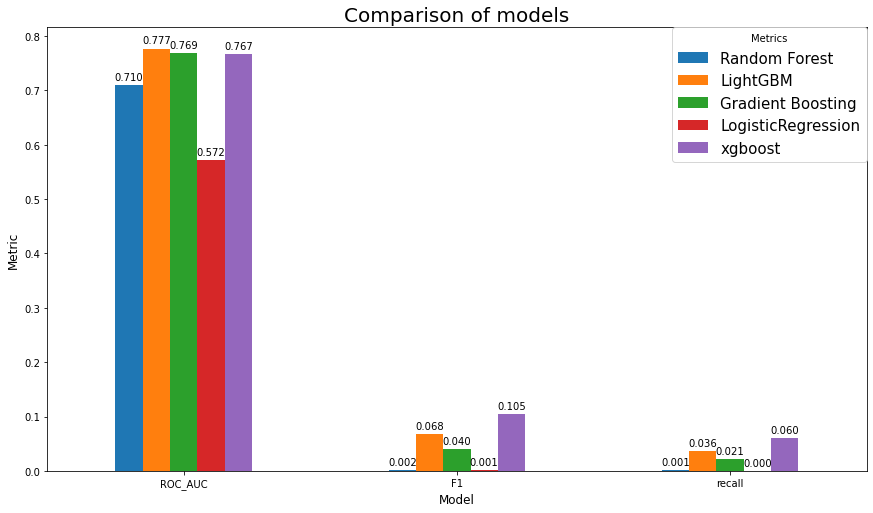

In [79]:
plot= df_models_result.plot.bar(rot=0, figsize=[12,7])
plt.title("Comparison of models", size=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0, title="Metrics", prop={'size':15})
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)

# Recherche des meilleurs hyperparamètres

Dans le kernel  "<citation>" le modèle LightGBM a été optimisé et les resultats du ROC_AUC ont augmenté. La valeur obtenue est de **0.79** en moyenne. avec les paramètres suivante :<br/>
    <div class="alert alert-block alert-success">
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1
    </div>
    
 En analysant les différents scoring on note également que le modèle **xgboost** est celui qui a une meilleure réprésentation du recall et du F1 dans la suite je vais analyser son optimisation 

In [14]:
over = SMOTE(random_state=42)
X_train_new, y_train_new = over.fit_resample(X_train, y_train)

In [15]:
X_train_set,X_valid_set, y_train_set,y_valid_set = train_test_split(
    X_train_new,y_train_new, test_size=0.2, random_state=42)

In [16]:
X_train_new.shape,X_train.shape

((452290, 606), (246005, 606))

In [6]:
n_estimators = [100]
subsample=[0.7, 0.8]
learning_rate=[0.1,0.2]
#learning_rate=[0.2]
parameters = {'n_estimators': n_estimators,
                 'subsample':subsample,
                 'learning_rate':learning_rate}

In [17]:
xgbgrid = GridSearchCV(xgb.XGBClassifier(),
                        param_grid = parameters,verbose=-1,cv=stratified_kfold,
                        scoring='roc_auc')

In [ ]:
xgbgrid.fit(X_train_set, y_train_set)

In [ ]:
xgbgrid.fit(X_train, y_train)

In [ ]:
filename = 'xgboost.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rfc_grid,file)
    
models_score = models_score.append(pd.DataFrame(
    {'Models' : ['xgboost'],
     'Training set' : [rfc_grid.best_score_],
     'Validation set' : [f1_score(rfc_grid.predict(X_valid_set), y_valid_set)]}),
                                   ignore_index=True)